In [1]:
#add necessary libraries
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stat
from scipy import optimize
import pysal as ps
from zipfile import ZipFile
from StringIO import StringIO
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


## 1. Data Loading

In [2]:
# load state gdp data (2014)
gdp = pd.read_csv('bea_gdp_by_state_in_millions.csv', header = 0, names=['fips', 'state', 'gdp'], index_col=['state'])
print gdp.head()
print gdp.columns
print len(gdp)

            fips      gdp
state                    
Alabama     1000   199440
Alaska      2000    57080
Arizona     4000   284156
Arkansas    5000   121395
California  6000  2311616
Index([u'fips', u'gdp'], dtype='object')
51


In [3]:
# load state capitals
caps = pd.read_csv('Capitals.csv', header = 0, index_col=['state'])
print caps.head()
print caps.columns
print len(caps)

            id abbrev      capital   latitude   longitude  population
state                                                                
Alabama      1     AL   Montgomery  32.380120  -86.300629      205764
Alaska       2     AK       Juneau  58.299740 -134.406794       31275
Arizona      4     AZ      Phoenix  33.448260 -112.075774     1445632
Arkansas     5     AR  Little Rock  34.748655  -92.274494      193524
California   6     CA   Sacramento  38.579065 -121.491014      466488
Index([u'id', u'abbrev', u'capital', u'latitude', u'longitude', u'population'], dtype='object')
50


In [4]:
# load state population centers
popcenter = pd.read_csv('CenPop2010_Mean_ST.txt', index_col=['STNAME'])
print popcenter.head()
print popcenter.columns

            STATEFP  POPULATION   LATITUDE   LONGITUDE
STNAME                                                
Alabama           1     4779736  33.008097  -86.756826
Alaska            2      710231  61.399882 -148.873973
Arizona           4     6392017  33.368266 -111.864310
Arkansas          5     2915918  35.142580  -92.655243
California        6    37253956  35.463595 -119.325359
Index([u'STATEFP', u'POPULATION', u'LATITUDE', u'LONGITUDE'], dtype='object')


In [58]:
# load state tax rates (all types)
tax = pd.read_excel('Taxes rates by state.xlsx', index_col=['State'])
print len(tax)

# clean col names to make easier to work with
tax.columns = ['State_Sales', 'Avg_Local_Sales', 'Combined_Sales', 'Max_Local_Sales'
               , 'Property', 'Income_Low', 'Income_High', 'Mature_Firm_HQ', 'New_Firm_HQ']
print tax.columns
#print tax.head()

# clean index names
tax.index =  [state.replace("\"", "").strip() for state in tax.index]
#print tax.index

# convert percentages to floats
tax['New_Firm_HQ'] = tax['New_Firm_HQ'].replace('%','',regex=True).astype('float')/100
tax['Mature_Firm_HQ'] = tax['Mature_Firm_HQ'].replace('%','',regex=True).astype('float')/100

tax = tax.fillna(0)

51
Index([u'State_Sales', u'Avg_Local_Sales', u'Combined_Sales',
       u'Max_Local_Sales', u'Property', u'Income_Low', u'Income_High',
       u'Mature_Firm_HQ', u'New_Firm_HQ'],
      dtype='object')


In [6]:
# What makes intuitive sense

'''
NONGRAVITY MODELS
Combined_Sales: highest spatial auto-correlation based on rook/queen
    you can only travel so far to buy stuff
Property: low spatial auto-corr (rook > queen marginally)
    since tied to land

POTENTIAL FOR GRAVITY MODEL
Income-Low vs. Income-High: lower for low income than for high income since richer people are more mobile
    also, look at gravity model here
Mature_Firm_HQ: high spatial auto-correlation
    also gravity model
New_Firm_HQ: even higher spatial auto-corr than mature
    new firms are more mobile than mature firms)
'''

'\nNONGRAVITY MODELS\nCombined_Sales: highest spatial auto-correlation based on rook/queen\n    you can only travel so far to buy stuff\nProperty: low spatial auto-corr (rook > queen marginally)\n    since tied to land\n\nPOTENTIAL FOR GRAVITY MODEL\nIncome-Low vs. Income-High: lower for low income than for high income since richer people are more mobile\n    also, look at gravity model here\nMature_Firm_HQ: high spatial auto-correlation\n    also gravity model\nNew_Firm_HQ: even higher spatial auto-corr than mature\n    new firms are more mobile than mature firms)\n'

In [7]:
# This is only for the shapes that will be used by PySAL to 
# build the spatial weights matrix
data = gpd.read_file('cb_2014_us_state_5m/cb_2014_us_state_5m.shp')
psGeom = ps.open('cb_2014_us_state_5m/cb_2014_us_state_5m.shp', 'r')

print data.columns

# clean state names
data['NAME'] = [statename.strip() for statename in data['NAME']]

Index([u'AFFGEOID',    u'ALAND',   u'AWATER',    u'GEOID',     u'LSAD',
           u'NAME',  u'STATEFP',  u'STATENS',   u'STUSPS', u'geometry'],
      dtype='object')


## 2. Build spatial weight matrices

### 2.1. Rook 

In [8]:
# We are building the spatial weight matrix and using the 
# state names as IDs of the matrix.

R = ps.buildContiguity(psGeom, criterion='rook', ids=data['NAME'].values.tolist())
R.transform = 'R' # normalize

Island ids:  [u'Puerto Rico', u'Commonwealth of the Northern Mariana Islands', u'Alaska', u'Hawaii', u'United States Virgin Islands', u'American Samoa', u'Guam']


In [9]:
#for (loc, neighbors) in R:
 #   print loc, neighbors

In [10]:
print type(R)

<class 'pysal.weights.weights.W'>


### 2.2. Queen 

In [11]:
# We are building the spatial weight matrix and using the 
# state names as IDs of the matrix. Noted that we
# running a 'queen', shared vertices, neighborhood test.

Q = ps.buildContiguity(psGeom, criterion='queen', ids=data['NAME'].values.tolist())
Q.transform = 'R' # normalize

Island ids:  [u'Puerto Rico', u'Commonwealth of the Northern Mariana Islands', u'Alaska', u'Hawaii', u'United States Virgin Islands', u'American Samoa', u'Guam']


### 2.4. Distance-weighted by population centers (50 by 50 matrix) 

In [24]:
clean = [i.strip() for i in popcenter.index.values.tolist()]
ids_set = set(clean)

In [69]:
points = [(popcenter['LATITUDE'][i], popcenter['LONGITUDE'][i]) for i in popcenter.index.values.tolist()]

In [41]:
ids = tax.index.values.tolist()

In [26]:
from math import sin, cos, sqrt, atan2, radians
def geodist(lon1,lat1,lon2,lat2):
    lat1 = radians(lat1)
    lon1 = radians(lon1)  
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    R = 6373.0
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

In [62]:
neighbors = {}
for state in ids:
    neighbors[state] = ids    

In [63]:
weights = {}

#count the states
i = 0

for state in ids:
    result=[]
    for a in xrange(0, 51):
        if i == a:
            b = 0
        else:
            b = 1.0/ geodist(points[i][0],points[i][1],points[a][0],points[a][1])
        result.append(b)
    weights[state] = result
    i += 1

In [64]:
w = ps.W(neighbors, weights)

In [65]:
w.transform = 'R'

In [66]:
# 3. subset queen spatial weights matrix to only those states
D_Income = ps.w_subset(w, ids)
D_Income.transform = 'R' # normalize
#print Q_Property.id_order

# 4. get and normalize tax rate values (dependent variable)
Y = tax['Income_High'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

# 5. calculate Moran's statistics for spatial auto-corr. with ROOK and QUEEN
mi_D = ps.Moran(Y, D_Income)
print
print 'Distance: ', mi_D.I, mi_D.p_sim


Distance:  -1.0573733028e-34 0.294


In [67]:
# 3. subset queen spatial weights matrix to only those states
D_Income = ps.w_subset(w, ids)
D_Income.transform = 'R' # normalize
#print Q_Property.id_order

# 4. get and normalize tax rate values (dependent variable)
Y = tax['Income_Low'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

# 5. calculate Moran's statistics for spatial auto-corr. with ROOK and QUEEN
mi_D = ps.Moran(Y, D_Income)
print
print 'Distance: ', mi_D.I, mi_D.p_sim


Distance:  0.0 0.082


### 2.5. Gravity model (???) 

In [68]:
weightsHQ = {}

#count the states
i = 0

for state in ids:
    result=[]
    for a in xrange(0, 51):
        dest = ids[a]
        if i == a:
            b = 0
        else:
            b = gdp['gdp'][dest]*1.0/ geodist(points[i][0],points[i][1],points[a][0],points[a][1]) 
        result.append(b)
    weightsHQ[state] = result
    i += 1

In [ ]:
for state in ids:
    print state
    for a in xrange(0,52):
        print a, ids[a]

In [70]:
g = ps.W(neighbors, weightsHQ)

In [71]:
g.transform = "R"

In [74]:
# 3. subset queen spatial weights matrix to only those states
G_HQTax = ps.w_subset(g, ids)
G_HQTax.transform = 'R' # normalize
#print Q_Property.id_order

# 4. get and normalize tax rate values (dependent variable)
Y = tax['New_Firm_HQ'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

# 5. calculate Moran's statistics for spatial auto-corr. with ROOK and QUEEN
mi_G = ps.Moran(Y, G_HQTax)
print
print 'HQ Tax Gravity: ', mi_G.I, mi_G.p_sim


HQ Tax Gravity:  -3.02106657943e-34 0.021


In [75]:
# 3. subset queen spatial weights matrix to only those states
G_HQTax = ps.w_subset(g, ids)
G_HQTax.transform = 'R' # normalize
#print Q_Property.id_order

# 4. get and normalize tax rate values (dependent variable)
Y = tax['Mature_Firm_HQ'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

# 5. calculate Moran's statistics for spatial auto-corr. with ROOK and QUEEN
mi_G = ps.Moran(Y, G_HQTax)
print
print 'HQ Tax Gravity: ', mi_G.I, mi_G.p_sim


HQ Tax Gravity:  2.41685326354e-34 0.179


## 3. Calculate spatial auto-correlations for tax rates (each type)
### Morans I (see lab9_sa from NYU Classes)

In [16]:
# Template

# Y is the normalized list of values

# Y = data['percent'].values
# Y = (Y-Y.mean())/Y.std() # <<<---- normalization


# W is the standardized dict. of all the weights. This can be 
# done by specifying 'R' as the matrix transformation. All the weights
# should add up to 1.

# W.transform = 'R'


# Execute the Moran's I calculation

# mi = ps.Moran(Y, W)

# This is the Moran's I value, that would tell us whether tax rates
# among states are clustered, or not.

# mi.I

# Check the p-value of the calculation. This has to be < 0.05 for our
# calculation to be statistically significant.

# mi.p_sim


# Very helpful documentation on PYSAL:
# https://media.readthedocs.org/pdf/pysal/latest/pysal.pdf

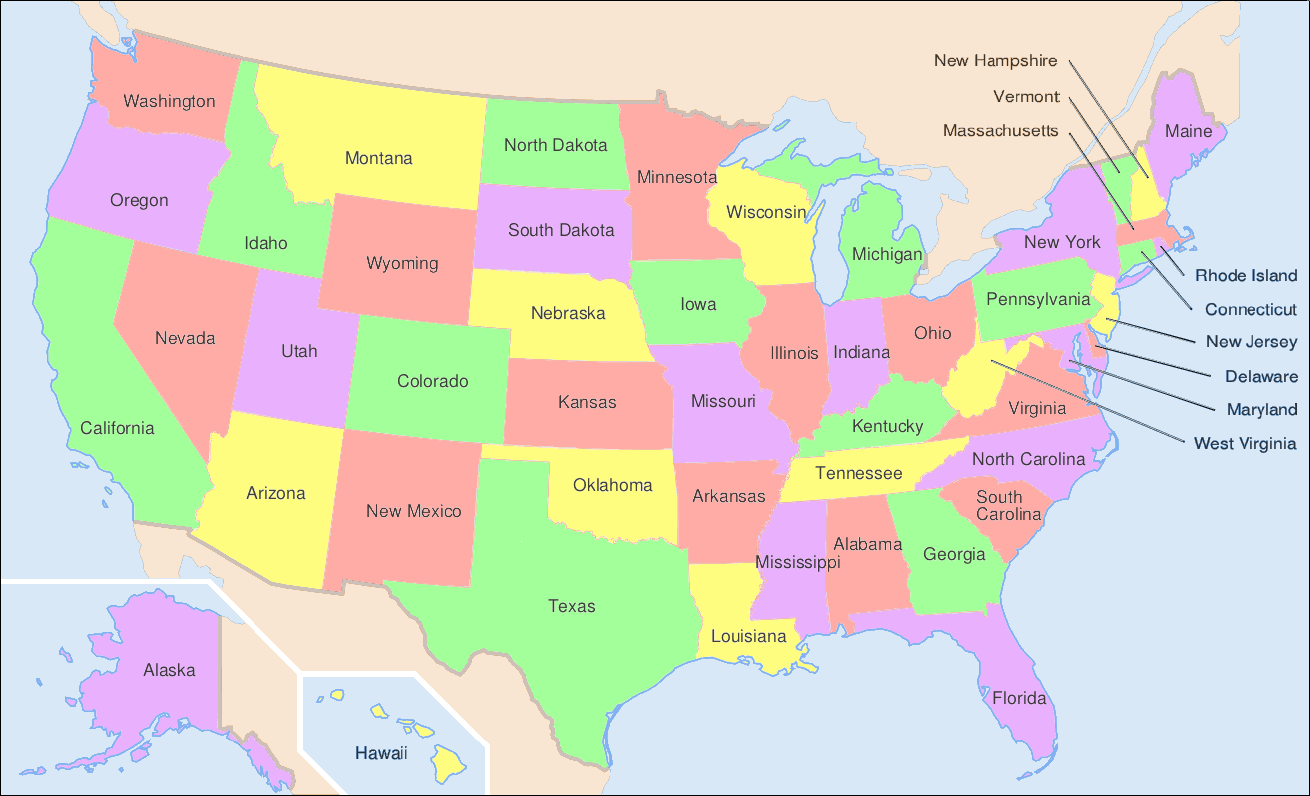

In [17]:
# have map handy!
from IPython.display import Image
Image(filename='state_map.png') 

### 3.1. Property Taxes with Rook vs. Queen methods

In [20]:
# 1. get data where tax rate is provided
print 'Number of States with Data: ', len(tax)
print
ids = tax.index.values.tolist()
#print ids # list of states with this tax rate provided

# 3. subset queen spatial weights matrix to only those states
Q_Sales = ps.w_subset(Q, ids)
Q_Sales.transform = 'R' # normalize
#print Q_Property.id_order

# 4. get and normalize tax rate values (dependent variable)
Y = tax['State_Sales'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

# 5. calculate Moran's statistics for spatial auto-corr. with ROOK and QUEEN
mi_Q = ps.Moran(Y, Q_Sales)
print
print 'Queen: ', mi_Q.I, mi_Q.p_sim

Number of States with Data:  51

Island ids:  [u'Alaska', u'Hawaii']

Queen:  -0.148484732177 0.072


In [23]:
# 1. get data where tax rate is provided
print 'Number of States with Data: ', len(tax)
print
ids = tax.index.values.tolist()
#print ids # list of states with this tax rate provided

# 3. subset queen spatial weights matrix to only those states
Q_Sales = ps.w_subset(Q, ids)
Q_Sales.transform = 'R' # normalize
#print Q_Property.id_order

# 4. get and normalize tax rate values (dependent variable)
Y = tax['Combined_Sales'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

# 5. calculate Moran's statistics for spatial auto-corr. with ROOK and QUEEN
mi_Q = ps.Moran(Y, Q_Sales)
print
print 'Queen: ', mi_Q.I, mi_Q.p_sim

Number of States with Data:  51

Island ids:  [u'Alaska', u'Hawaii']

Queen:  0.110811227854 0.095


### Conclusion: significant spatial auto-correlation for state property taxes
#### Note: US has very few states where Rook and Queen really make a difference, so if UT sim. to NM and AZ sim. to CO, Queen > Rook as we see here

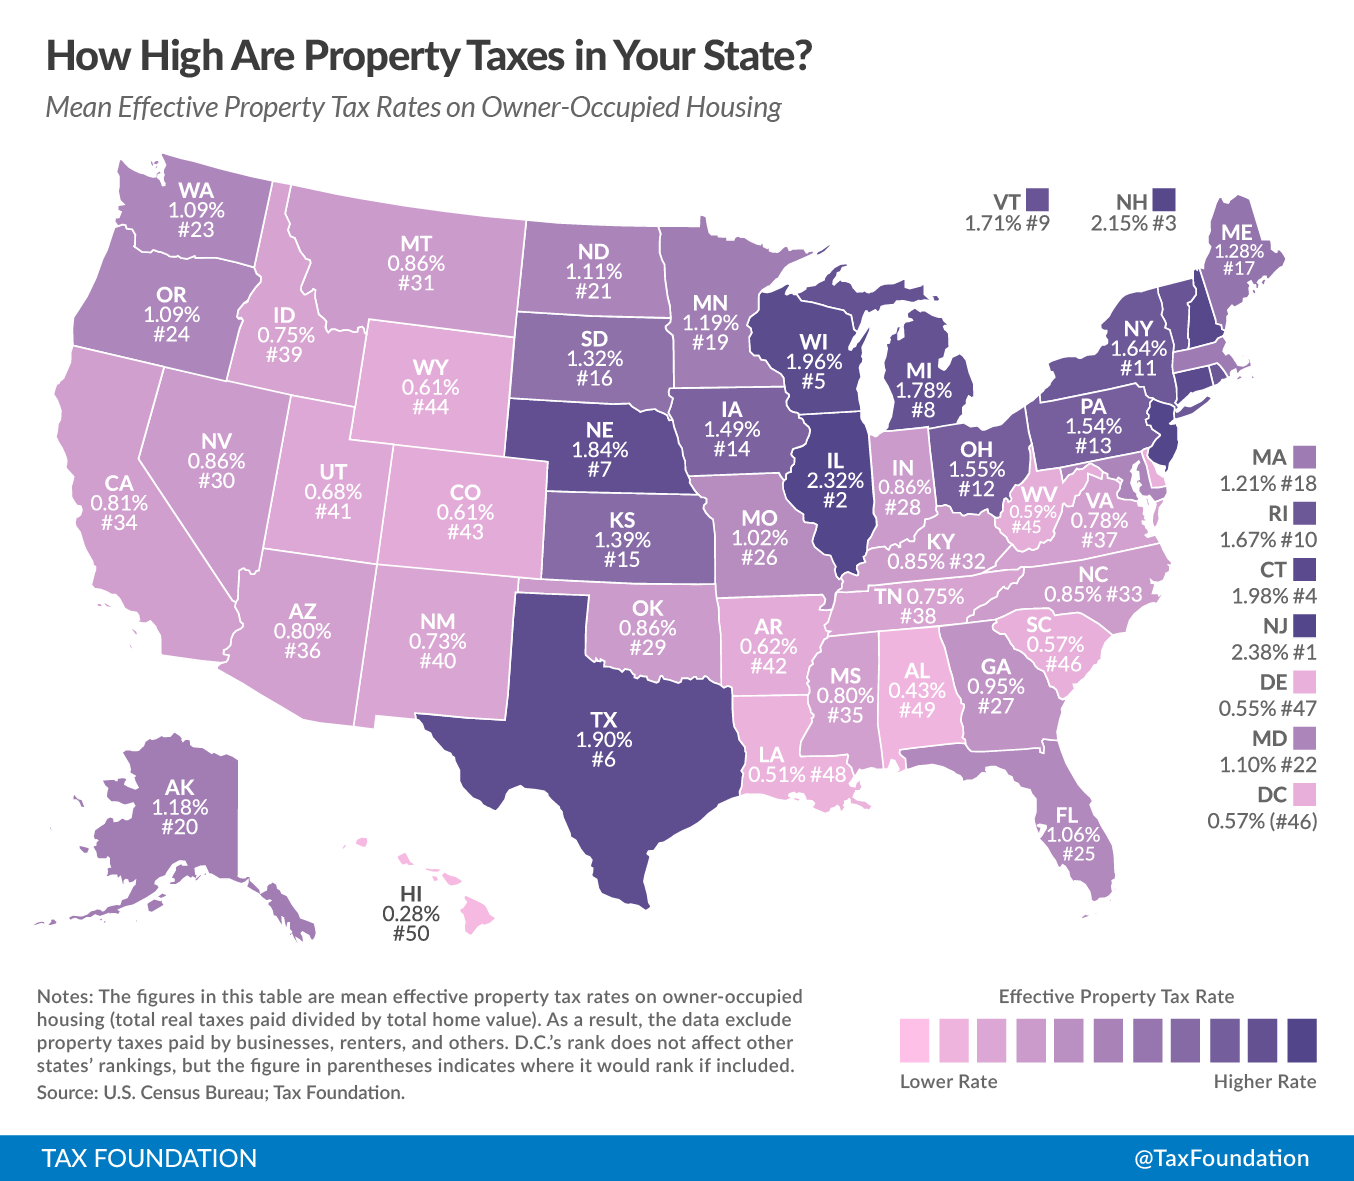

In [105]:
# Does this line up with what we expect? (note: numbers don't quite tie out with our data but are close)
Image(filename='property_tax_map.png') 

### Now consider that people like to be near other people (not on a farm on the border of North and South Dakota) 

In [111]:
print tax_notnull['Property']

#points = [(10, 10), (20, 10), (40, 10), (15, 20), (30, 20), (30, 30)]
#>>> wid = pysal.threshold_continuousW_from_array(points,14.2)
#>>> wid.weights[0]
#[0.10000000000000001, 0.089442719099991588]

Alabama                 0.0033
Alaska                  0.0104
Arizona                 0.0072
Arkansas                0.0052
California              0.0074
Colorado                0.0060
Connecticut             0.0163
Delaware                0.0043
Florida                 0.0097
Georgia                 0.0083
Hawaii                  0.0026
Idaho                   0.0069
Illinois                0.0173
Indiana                 0.0085
Iowa                    0.0129
Kansas                  0.0129
Kentucky                0.0072
Louisiana               0.0018
Maine                   0.0109
Maryland                0.0087
Massachusetts           0.0104
Michigan                0.0162
Minnesota               0.0105
Mississippi             0.0052
Missouri                0.0091
Montana                 0.0083
Nebraska                0.0176
Nevada                  0.0084
New Hampshire           0.0186
New Jersey              0.0189
New Mexico              0.0055
New York                0.0123
North Ca